In [238]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage import io # 미니맵 처리
from sklearn.preprocessing import MinMaxScaler

# pyautogui, pillow, opencv,

# https://developer.riotgames.com/docs/lol
api_key  = "RGAPI-5b67d4a8-99d5-4bcc-9e3f-e0a04c83f655"
kr_api   = "https://kr.api.riotgames.com"
asia_api = "https://asia.api.riotgames.com"

In [240]:
match_basic_data.keys()

dict_keys(['metadata', 'info'])

In [2]:
# riot api
# RGAPI-7878fe8c-f7f2-4e2e-985f-8103910d5e13

# RATE LIMITS
# 20 requests every 1 seconds(s)
# 100 requests every 2 minutes(s)

# 플레이어 동선 정확도 높이기
# 각 라인별 zone을 좌표로 설정하기
# 죽은 챔피언 그 위치에서 좌표가 찍힘. 따라서 킬 로그 먼저 확인한 이후에, 부활하기까지의 시간이 정확히 1분 단위에 포함된다면 좌표를 찍지 말아야 함.

In [202]:
# match_data[4]["participantFrames"]
# match_basic_data["info"]

In [ ]:
라인형
로밍형

# 심심풀이 뭐시기 분석
# 정글의 시각에서 풀어낸 분석
# (밴픽) 선픽하는 라인에 따른 승률

In [221]:
match_basic_data.keys()
# match_data[1].keys()
# time_match["info"].keys()

dict_keys(['metadata', 'info'])

In [225]:
# match_data[1]["participantFrames"]["10"]
match_basic_data["info"].keys()

dict_keys(['gameCreation', 'gameDuration', 'gameId', 'gameMode', 'gameName', 'gameStartTimestamp', 'gameType', 'gameVersion', 'mapId', 'participants', 'platformId', 'queueId', 'teams', 'tournamentCode'])

# 밴픽 (첫 사건)

In [233]:
match_basic_data["info"]["teams"][0]

{'bans': [{'championId': 39, 'pickTurn': 1},
  {'championId': 3, 'pickTurn': 2},
  {'championId': -1, 'pickTurn': 3},
  {'championId': 238, 'pickTurn': 4},
  {'championId': 64, 'pickTurn': 5}],
 'objectives': {'baron': {'first': False, 'kills': 0},
  'champion': {'first': False, 'kills': 21},
  'dragon': {'first': False, 'kills': 0},
  'inhibitor': {'first': False, 'kills': 0},
  'riftHerald': {'first': True, 'kills': 1},
  'tower': {'first': False, 'kills': 2}},
 'teamId': 100,
 'win': False}

In [235]:
match_basic_data["info"]["teams"][1]

{'bans': [{'championId': 711, 'pickTurn': 6},
  {'championId': 236, 'pickTurn': 7},
  {'championId': -1, 'pickTurn': 8},
  {'championId': 64, 'pickTurn': 9},
  {'championId': 23, 'pickTurn': 10}],
 'objectives': {'baron': {'first': True, 'kills': 1},
  'champion': {'first': True, 'kills': 32},
  'dragon': {'first': True, 'kills': 2},
  'inhibitor': {'first': True, 'kills': 1},
  'riftHerald': {'first': False, 'kills': 0},
  'tower': {'first': True, 'kills': 8}},
 'teamId': 200,
 'win': True}

- 챔피언 관련
- 인플레이 관련
- 룬 관련
- 아이템 관련

- 3렙 탑갱이 승리에 끼치는 영향
- 처음 바위게의 중요성
- 첫 전령 vs 첫 용 
- 정글 동선 바텀 위주 vs 탑 위주

- (미드, 정글), (탑, 정글) 좋은 조합

스폰시간 <br>
대부분 정글 몬스터: 1분 30초, 리젠 2분 30초<br>
돌거북, 심술 두꺼비: 1분 42초, 리젠 2분 30초 <br>
협곡 바위 게: 3분 15초, 리젠 2분 30초,  처음엔 위아래 다뜨고 그 뒤엔 랜덤

# 티어별 유저 기본 데이터 가져오기 함수
- https://developer.riotgames.com/apis#league-v4
- /lol/league/v4/entries/{queue}/{tier}/{division}

In [3]:
def get_player_by_tier(api_key, queue="RANKED_SOLO_5x5", tier="challenger", division=1, page=1):
    high_tier = ["challenger", "grandmaster", "master"]
    
    # 마스터 이상
    if tier in high_tier:
        tier_api = f"{kr_api}/lol/league/v4/{tier}leagues/by-queue/{queue}?page={page}&api_key={api_key}"
        
    # 다이아 이하
    else:
        division = "I" * division
        tier_api = f"{kr_api}/lol/league/v4/entries/{queue}/{tier}/{division}?page={page}&api_key={api_key}"
        
    data      = requests.get(tier_api).json()
    league_df = pd.DataFrame(data)
    
    return league_df

# 소환사 데이터 가져오기 함수
https://developer.riotgames.com/apis#account-v1

In [147]:
def get_summoner_data(api_key, summoner_id):
    """
    소환사에 관한 정보를 가져오는 함수입니다.
    
    api_key    : Riot에서 발급받은 api key
    summoner_id: 소환사 id
    """
    summoner_api  = f"{kr_api}/lol/summoner/v4/summoners/{summoner_id}?api_key={api_key}"
    response      = requests.get(summoner_api)
    summoner_data = response.json()
    
    return summoner_data

# match 리스트 가져오기 함수
- https://developer.riotgames.com/apis#match-v5
- /lol/match/v5/matches/by-puuid/{puuid}/ids

In [178]:
def get_matches_by_summoner_puuid(api_key, summoner_puuid, start=0, count=20):
    """
    소환사의 puuid로 match list 가져오는 함수입니다.
    
    api_key       : Riot에서 발급받은 api key
    summoner_puuid: Riot에서 제공한 소환사의 고유 ID
    start         : 가져올 매치의 시작 index
    count         : 가져올 매치의 개수 (max: 0 to 100)
    """
    if count > 100:
        raise Exception("최대 100개까지 가져올 수 있습니다.")
        
    match_list_api = f"{asia_api}/lol/match/v5/matches/by-puuid/{summoner_puuid}/ids?start={start}&count={count}&api_key={api_key}"
    response       = requests.get(match_list_api)
    match_list     = response.json()
    
    return match_list

# match 데이터 가져오기 함수
- https://developer.riotgames.com/apis#match-v5/GET_getMatch
- /lol/match/v5/matches/{matchId}

In [182]:
def get_match_by_match_id(api_key, match_id):
    match_data_api   = f"{asia_api}/lol/match/v5/matches/{match_id}?api_key={api_key}"
    response         = requests.get(match_data_api)
    match_basic_data = response.json()
    
    return match_basic_data

# 타임라인 match 데이터 가져오기 함수

In [ ]:
def get_timeline_match_by_match_id(api_key, match_id):
    timeline_match_api = f"{asia_api}/lol/match/v5/matches/{match_id}/timeline?api_key={api_key}"
    response           = requests.get(timeline_match_api)
    time_match         = response.json()
    
    return time_match

In [189]:
# 리그에 존재하는 유저 데이터 가져오기
league_df = get_player_by_tier(api_key, tier="challenger", page=1)

# 소환사 데이터 가져오기
summoner_id    = league_df["entries"][0]["summonerId"]
summoner_data  = get_summoner_data(api_key, summoner_id)
summoner_puuid = summoner_data["puuid"]

# match_list 가져오기
match_list = get_matches_by_summoner_puuid(api_key, summoner_puuid, start=0, count=20)

# 기본 match 데이터 가져오기
match_num = 3
match_id  = match_list[match_num]
match_basic_data = get_match_by_match_id(api_key, match_id)

# timeline match 데이터 가져오기
time_match = get_timeline_match_by_match_id(api_key, match_id)
time_match

In [190]:
spectator_api = f"https://kr.api.riotgames.com/lol/spectator/v4/featured-games"
response = requests.get(spectator_api)
data = response.json()
data

{'status': {'message': 'Unauthorized', 'status_code': 401}}

## 시간 변환

In [138]:
# 소환사의 협곡 map_id == 11

# gameDuration 분으로 변환
print(1425655 / 1000 / 60)

# gameCreation 변환
from datetime import datetime
ts = int("1632595525")
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))
print(match_basic_data["info"]["gameCreation"])

23.760916666666667
2021-09-25 18:45:25
1632595525000


In [141]:
# print(match_basic_data.keys())
# print(match_basic_data["info"].keys())
# print(match_basic_data["info"]["platformId"])
# print(match_basic_data["info"]["queueId"])
# print(match_basic_data["info"]["tournamentCode"])

## 스펠 api
- https://ddragon.leagueoflegends.com/cdn/11.19.1/data/ko_KR/summoner.json

In [67]:
# timeline_match_api = f"{asia_api}/lol/match/v5/matches/{match_list[match_num]}/timeline?api_key={api_key}"

# response   = requests.get(timeline_match_api)
# time_match = response.json()

In [68]:
time_match.keys()

dict_keys(['metadata', 'info'])

In [69]:
time_match["metadata"]

{'dataVersion': '2',
 'matchId': 'KR_5476475155',
 'participants': ['sh9DiMLwiS0GhV2W8hIGkhb5ingIF2uJ1oHLZYdLL9Rk1OPR0JOHznCeuUeqRNuyqWgaNu1VaBv_hA',
  'N9tFWJKRO03q6Gsx-cGvyFW65eI6ve7AIpi4OUJYCvdfvVfCpENejB60ULpVrN2u8bD9LVTaK75LlA',
  'WIKqhlbDxVig1xRPYuap6bOwEfcEoXVWEWjJfxUJfMwqAzM8evmOQbeUttP0OmchnxPCyB-7iuwmqg',
  'ISw2AJsuc8q9O6xUq6C9NwZjsQYhnaH9cfxQGqsRs5vpIHUZID2Sska3xubwe7Fa3RSB1S7dleuSOw',
  '1k1SZkBrNh3II-Mr9sb8kM3KmAk81UaC2JWmAtQBTzpfIYuJJLWtRoR-NtT_JE0fITKE7sowmYY7Mw',
  'Crtl-wq4RbQ-ZGbiPVUmRQslwZJ2lwwNCFry7Ry3UZWX2egGrn0qFkohP1ibhFSVeL6foz27qIdWfQ',
  'puBj8EjJ3xU43rlT27gTJLuzMr38k2-shzmWcT_0q8k5eYMhB2vnTvuUI3F1AJp6GLtxc5RejIXaaA',
  'CO-DOGnod8-IlvsmYEVjvnrohLcsrGnLR3JeVXUrZFpExH1Ta3onqNxLHvS9Xm18utYLeStoop8RVw',
  '3K2M1CDXgNqfxc4ctntznmXhJjOQXrt_Xkr9y7FM-2rxSpUl3f6fPUhehORhb87Du11NW34XoGtG0w',
  'jk_O1XQ-1qGCgRv2WoWyyGqI9rhELKVi62wOyOyStLJ1YJRmf1ckCW_J6HGyr0N2Ai7PV6X7hHLgsQ']}

In [70]:
time_match["info"]["participants"]

[{'participantId': 1,
  'puuid': 'sh9DiMLwiS0GhV2W8hIGkhb5ingIF2uJ1oHLZYdLL9Rk1OPR0JOHznCeuUeqRNuyqWgaNu1VaBv_hA'},
 {'participantId': 2,
  'puuid': 'N9tFWJKRO03q6Gsx-cGvyFW65eI6ve7AIpi4OUJYCvdfvVfCpENejB60ULpVrN2u8bD9LVTaK75LlA'},
 {'participantId': 3,
  'puuid': 'WIKqhlbDxVig1xRPYuap6bOwEfcEoXVWEWjJfxUJfMwqAzM8evmOQbeUttP0OmchnxPCyB-7iuwmqg'},
 {'participantId': 4,
  'puuid': 'ISw2AJsuc8q9O6xUq6C9NwZjsQYhnaH9cfxQGqsRs5vpIHUZID2Sska3xubwe7Fa3RSB1S7dleuSOw'},
 {'participantId': 5,
  'puuid': '1k1SZkBrNh3II-Mr9sb8kM3KmAk81UaC2JWmAtQBTzpfIYuJJLWtRoR-NtT_JE0fITKE7sowmYY7Mw'},
 {'participantId': 6,
  'puuid': 'Crtl-wq4RbQ-ZGbiPVUmRQslwZJ2lwwNCFry7Ry3UZWX2egGrn0qFkohP1ibhFSVeL6foz27qIdWfQ'},
 {'participantId': 7,
  'puuid': 'puBj8EjJ3xU43rlT27gTJLuzMr38k2-shzmWcT_0q8k5eYMhB2vnTvuUI3F1AJp6GLtxc5RejIXaaA'},
 {'participantId': 8,
  'puuid': 'CO-DOGnod8-IlvsmYEVjvnrohLcsrGnLR3JeVXUrZFpExH1Ta3onqNxLHvS9Xm18utYLeStoop8RVw'},
 {'participantId': 9,
  'puuid': '3K2M1CDXgNqfxc4ctntznmXhJjOQXrt_Xkr9y7

In [71]:
time_match["info"].keys()

dict_keys(['frameInterval', 'frames', 'gameId', 'participants'])

In [72]:
match_data = time_match["info"]["frames"]

In [73]:
"""
events: 게임 내에서 발생한 사건 데이터
participantFrames: 각 플레이어 인게임 정보
timestamp: 기록된 시간(1분마다 기록이 된다.)

match_data는 1분 단위로 기록됩니다.
"""
print(len(match_data))
match_data[0].keys()

32


dict_keys(['events', 'participantFrames', 'timestamp'])

In [74]:
# match_data[0]["participantFrames"]["1"]["championStats"]
# match_basic_data["info"]["participants"][1]

## 한 경기 내 모든 이벤트 종류

In [237]:
match_list

['KR_5484141718',
 'KR_5483898355',
 'KR_5483875617',
 'KR_5483912077',
 'KR_5483135876',
 'KR_5483120112',
 'KR_5483005343',
 'KR_5483010209',
 'KR_5482433246',
 'KR_5482402065',
 'KR_5482286783',
 'KR_5482233972',
 'KR_5481746121',
 'KR_5481525007',
 'KR_5481486390',
 'KR_5481450839',
 'KR_5481304844',
 'KR_5480808923',
 'KR_5480748019',
 'KR_5480783413']

In [236]:
event_types = []
for match in match_data:
    for event in match["events"]:
        event_types.append(event["type"])
list(set(event_types))

['ELITE_MONSTER_KILL',
 'TURRET_PLATE_DESTROYED',
 'WARD_PLACED',
 'BUILDING_KILL',
 'PAUSE_END',
 'GAME_END',
 'CHAMPION_SPECIAL_KILL',
 'ITEM_PURCHASED',
 'LEVEL_UP',
 'ITEM_UNDO',
 'WARD_KILL',
 'SKILL_LEVEL_UP',
 'ITEM_DESTROYED',
 'ITEM_SOLD',
 'CHAMPION_KILL']

# 플레이어 포지션 구분

포지션을 구분하는 기준에 관련한 Riot docs 입니다. <br>
https://riot-api-libraries.readthedocs.io/en/latest/roleid.html
- Role과 Lane 데이터를 사용하여 Postion을 정하면 87.5%의 정확도를 가집니다.

> The easiest (and most inaccurate) way to correct roles is to just use the Role and Lane data and convert to Position based on the below mapping. This yields about 87.5% accuracy. <br>
    (MID_LANE, SOLO): MIDDLE, <br>
    (TOP_LANE, SOLO): TOP, <br>
    (JUNGLE, NONE): JUNGLE, <br>
    (BOT_LANE, DUO_CARRY): BOTTOM, <br>
    (BOT_LANE, DUO_SUPPORT): UTILITY <br>

In [76]:
match_data[10].keys()

dict_keys(['events', 'participantFrames', 'timestamp'])

In [77]:
print(match_basic_data.keys())
print(match_basic_data["info"].keys())

dict_keys(['metadata', 'info'])
dict_keys(['gameCreation', 'gameDuration', 'gameId', 'gameMode', 'gameName', 'gameStartTimestamp', 'gameType', 'gameVersion', 'mapId', 'participants', 'platformId', 'queueId', 'teams', 'tournamentCode'])


In [78]:
# match_basic_data["info"]["participants"][n]

In [104]:
match_data[2]["events"]

[{'itemId': 3340,
  'participantId': 2,
  'timestamp': 64896,
  'type': 'ITEM_DESTROYED'},
 {'itemId': 3364,
  'participantId': 2,
  'timestamp': 64896,
  'type': 'ITEM_PURCHASED'},
 {'levelUpType': 'NORMAL',
  'participantId': 7,
  'skillSlot': 1,
  'timestamp': 75000,
  'type': 'SKILL_LEVEL_UP'},
 {'levelUpType': 'NORMAL',
  'participantId': 4,
  'skillSlot': 2,
  'timestamp': 82756,
  'type': 'SKILL_LEVEL_UP'},
 {'levelUpType': 'NORMAL',
  'participantId': 3,
  'skillSlot': 3,
  'timestamp': 84782,
  'type': 'SKILL_LEVEL_UP'},
 {'levelUpType': 'NORMAL',
  'participantId': 2,
  'skillSlot': 2,
  'timestamp': 87518,
  'type': 'SKILL_LEVEL_UP'},
 {'levelUpType': 'NORMAL',
  'participantId': 9,
  'skillSlot': 1,
  'timestamp': 87651,
  'type': 'SKILL_LEVEL_UP'},
 {'levelUpType': 'NORMAL',
  'participantId': 10,
  'skillSlot': 3,
  'timestamp': 88515,
  'type': 'SKILL_LEVEL_UP'},
 {'levelUpType': 'NORMAL',
  'participantId': 6,
  'skillSlot': 1,
  'timestamp': 96221,
  'type': 'SKILL_LEV

In [79]:
n = 1
match_basic_data["info"]["participants"][n]["summonerId"]
match_basic_data["info"]["participants"][n]["championId"]
print(match_basic_data["info"]["participants"][n]["puuid"])
print(match_basic_data["info"]["participants"][n]["championName"])
# print(match_basic_data["info"]["participants"][n]["participantId"])
# print(match_basic_data["info"]["participants"][n]["teamId"])

print(match_basic_data["info"]["participants"][n]["role"])
print(match_basic_data["info"]["participants"][n]["lane"])
print(match_basic_data["info"]["participants"][n]["individualPosition"])
print(match_basic_data["info"]["participants"][n]["teamPosition"])

N9tFWJKRO03q6Gsx-cGvyFW65eI6ve7AIpi4OUJYCvdfvVfCpENejB60ULpVrN2u8bD9LVTaK75LlA
Ekko
NONE
JUNGLE
JUNGLE
JUNGLE


In [80]:
match_basic_data["info"].keys()

dict_keys(['gameCreation', 'gameDuration', 'gameId', 'gameMode', 'gameName', 'gameStartTimestamp', 'gameType', 'gameVersion', 'mapId', 'participants', 'platformId', 'queueId', 'teams', 'tournamentCode'])

In [107]:
# match_basic_data["info"]["participants"][1]
match_data[1].keys()

dict_keys(['events', 'participantFrames', 'timestamp'])

In [109]:
match_data[1]["participantFrames"]["2"]

{'x': 7081, 'y': 4297}

In [82]:
print(time_match["info"].keys())
time_match["info"]["participants"]

# 스마와 정글몹 킬 수로 정글러 파악 가능
# match_data[-1]["participantFrames"]["4"]["jungleMinionsKilled"]

# 미니언 킬 수, 레벨이 가장 낮은 플레이어가 서폿

dict_keys(['frameInterval', 'frames', 'gameId', 'participants'])


[{'participantId': 1,
  'puuid': 'sh9DiMLwiS0GhV2W8hIGkhb5ingIF2uJ1oHLZYdLL9Rk1OPR0JOHznCeuUeqRNuyqWgaNu1VaBv_hA'},
 {'participantId': 2,
  'puuid': 'N9tFWJKRO03q6Gsx-cGvyFW65eI6ve7AIpi4OUJYCvdfvVfCpENejB60ULpVrN2u8bD9LVTaK75LlA'},
 {'participantId': 3,
  'puuid': 'WIKqhlbDxVig1xRPYuap6bOwEfcEoXVWEWjJfxUJfMwqAzM8evmOQbeUttP0OmchnxPCyB-7iuwmqg'},
 {'participantId': 4,
  'puuid': 'ISw2AJsuc8q9O6xUq6C9NwZjsQYhnaH9cfxQGqsRs5vpIHUZID2Sska3xubwe7Fa3RSB1S7dleuSOw'},
 {'participantId': 5,
  'puuid': '1k1SZkBrNh3II-Mr9sb8kM3KmAk81UaC2JWmAtQBTzpfIYuJJLWtRoR-NtT_JE0fITKE7sowmYY7Mw'},
 {'participantId': 6,
  'puuid': 'Crtl-wq4RbQ-ZGbiPVUmRQslwZJ2lwwNCFry7Ry3UZWX2egGrn0qFkohP1ibhFSVeL6foz27qIdWfQ'},
 {'participantId': 7,
  'puuid': 'puBj8EjJ3xU43rlT27gTJLuzMr38k2-shzmWcT_0q8k5eYMhB2vnTvuUI3F1AJp6GLtxc5RejIXaaA'},
 {'participantId': 8,
  'puuid': 'CO-DOGnod8-IlvsmYEVjvnrohLcsrGnLR3JeVXUrZFpExH1Ta3onqNxLHvS9Xm18utYLeStoop8RVw'},
 {'participantId': 9,
  'puuid': '3K2M1CDXgNqfxc4ctntznmXhJjOQXrt_Xkr9y7

# 플레이어 동선 시각화 (726*600)

In [112]:
axes   = []
minute = 3 # 3분에서 바텀 상황 리플레이 돌려보자.

for order_num in match_data[minute]["participantFrames"]:
    cur_position = match_data[minute]["participantFrames"][order_num]["position"]
    x, y = cur_position["x"], cur_position["y"]
    axes.append([x, y])

In [113]:
x_range = np.array([0, 15000]).reshape((-1, 1))
y_range = np.array([0, 15000]).reshape((-1, 1)) 

# x 따로, y 따로
x_axes = [[ax[0]] for ax in axes]
y_axes = [[ax[1]] for ax in axes]

# 0부터 50, 680 부터 726, 총 96
player_x_scaler = MinMaxScaler(feature_range=(40, 680)).fit(x_range)
# player_x_scaler = MinMaxScaler(feature_range=(0, 726)).fit(x_range)

# 0부터 20, 580부터 600, 총 40
player_y_scaler = MinMaxScaler(feature_range=(10, 580)).fit(y_range)
# player_y_scaler = MinMaxScaler(feature_range=(0, 600)).fit(y_range)

player_x_position = player_x_scaler.transform(x_axes)
player_y_position = player_y_scaler.transform(y_axes)

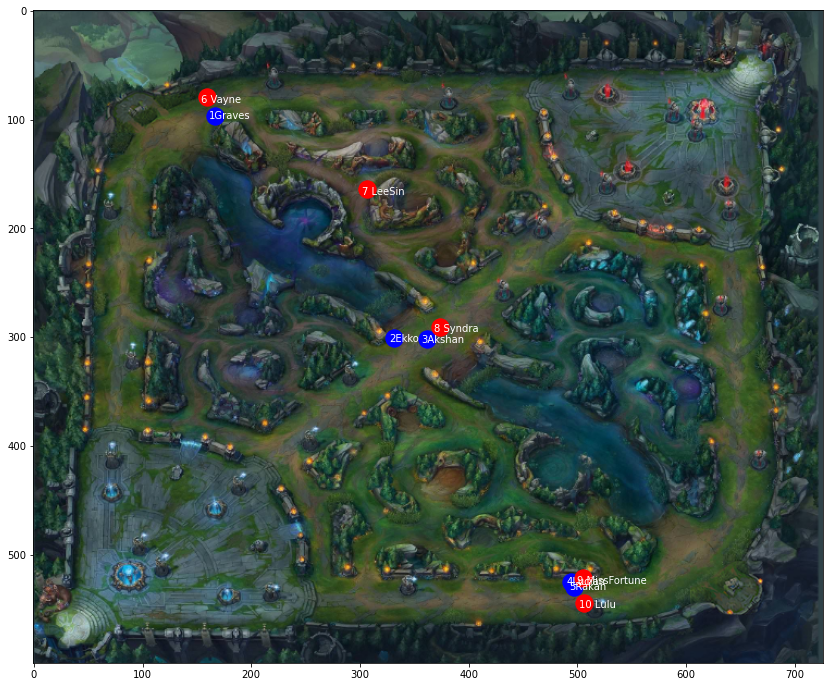

In [114]:
# 726 * 600 사이즈
map_url = "https://preview.redd.it/anfqyl1ef2041.png?width=726&format=png&auto=webp&s=a93e43da6d4e0f702cd54fafa5dacc3111bce8fb"
image   = io.imread(map_url)
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

i = 1
for position_x, position_y in zip(player_x_position, player_y_position):
    champion = match_basic_data["info"]["participants"][i - 1]["championName"]
    # blue 팀
    if i < 6:
        # 각각의 값은 이미지에 맞게 좌표를 추가적 스케일링을 진행한 것입니다.
        ax.scatter(position_x + 15, 600 - position_y - 15, c="blue", s=300)
        ax.annotate(text=f"{i}{champion}",  xy=(position_x + 10, 600 - position_y - 12), color="white")
    
    # red 팀
    else:
        # 각각의 값은 이미지에 맞게 좌표를 추가적 스케일링을 진행한 것입니다.
        ax.scatter(position_x - 30 + 20, 600 - position_y + 30 - 30, c="red", s=300)
        ax.annotate(text=f"{i} {champion}",  xy=(position_x - 35 + 20, 600 - position_y + 35 - 30), color="white")
    i += 1

ax.axis('on')
ax.imshow(image)
plt.show()

In [61]:
# match_data[minute]["events"]
match_data[minute + 1]["events"]

[{'creatorId': 5,
  'timestamp': 181402,
  'type': 'WARD_PLACED',
  'wardType': 'YELLOW_TRINKET'},
 {'itemId': 1055,
  'participantId': 8,
  'timestamp': 184075,
  'type': 'ITEM_PURCHASED'},
 {'levelUpType': 'NORMAL',
  'participantId': 4,
  'skillSlot': 2,
  'timestamp': 186535,
  'type': 'SKILL_LEVEL_UP'},
 {'levelUpType': 'NORMAL',
  'participantId': 7,
  'skillSlot': 2,
  'timestamp': 189468,
  'type': 'SKILL_LEVEL_UP'},
 {'level': 4, 'participantId': 3, 'timestamp': 197142, 'type': 'LEVEL_UP'},
 {'levelUpType': 'NORMAL',
  'participantId': 3,
  'skillSlot': 2,
  'timestamp': 197879,
  'type': 'SKILL_LEVEL_UP'},
 {'itemId': 2003,
  'participantId': 5,
  'timestamp': 198079,
  'type': 'ITEM_DESTROYED'},
 {'level': 3, 'participantId': 6, 'timestamp': 198113, 'type': 'LEVEL_UP'},
 {'itemId': 2003,
  'participantId': 4,
  'timestamp': 199882,
  'type': 'ITEM_DESTROYED'},
 {'levelUpType': 'NORMAL',
  'participantId': 6,
  'skillSlot': 2,
  'timestamp': 200882,
  'type': 'SKILL_LEVEL_UP'

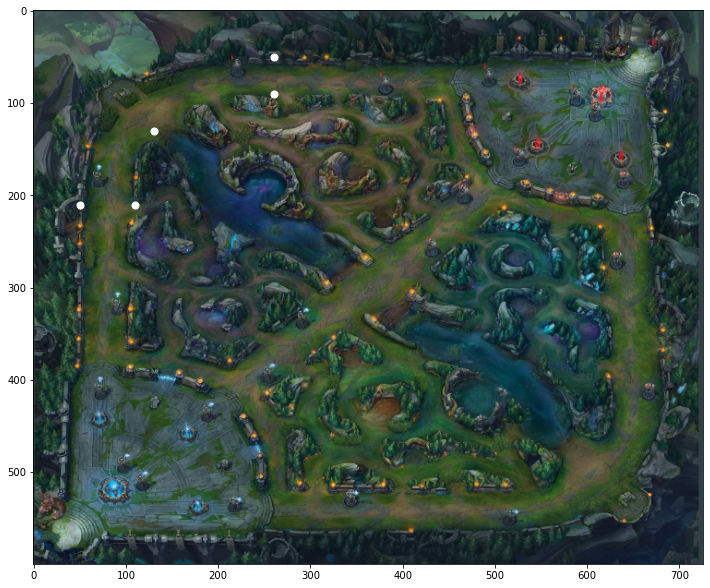

<Figure size 432x288 with 0 Axes>

In [34]:
# 0부터 50, 680부터 726, 총 96
# 0부터 20, 580부터 600, 총 40

img_url = "https://preview.redd.it/anfqyl1ef2041.png?width=726&format=png&auto=webp&s=a93e43da6d4e0f702cd54fafa5dacc3111bce8fb"
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter(
    [50, 110, 260, 260, 130],
    [210, 210, 50, 90, 130],
    c='white',
    s=50
)
ax.axis('on')
ax.imshow(io.imread(img_url))
plt.show()

ax.set_xlim(0, 1200)
ax.set_ylim(1200, 0)
plt.tight_layout()
plt.show()

# x=210, y=210


In [35]:
# 공식 사이트에 존재하는 map image
# http://ddragon.leagueoflegends.com/cdn/6.8.1/img/map/map11.png

# 챔피언 조합 분석
- 점수 기준
kda, 챔피언 딜량, 받은 데미지, 구조물 딜량, 오브젝트 딜량, 승패 유무, 흭득골드량, 미니언 처치 수

## 탑, 정글
- 각 라인의 챔프 점수 구하기
- 두 라인의 조합에서의 점수 구하기

In [115]:
# match_basic_data["info"]["participants"][0]
# assists, championId, championName, damageDealtToBuildings, damageDealtToObjectives, damageSelfMitigated
# gameEndedInEarlySurrender, gameEndedInSurrender, goldEarned, individualPosition,
# totalDamageDealtToChampions, physicalDamageTaken, totalMinionsKilled

## 미드, 정글